In [3]:
import sklearn
import matplotlib.pyplot as plt
from generate_data import *


MARKERS = dict(zip(ALGO, "oX^s*"))  # circle, cross, triangle, square, start
COLORS = dict(zip(ALGO, ["green", "yellow", "red", "purple", "blue"]))  # circle, cross, triangle, square, start


def plot_lines(xy, label):
    lines = [g[1] for g in df.groupby("line", group_keys=False)]
    plt.figure(figsize=(20, 10))
    alpha = 1 / np.sqrt(len(lines))
    algos = set()
    for line in reversed(lines):
        x,y = xy[line.index].T
        algo = line["algo"].iloc[0]
        marker = MARKERS[algo]
        color = COLORS[algo]
        if algo not in algos:
            algos.add(algo)
        else:
            algo = None
        plt.plot(x, y, marker=marker, markersize=10, markevery=[0,-1], c=color, alpha=alpha, linewidth=1, label=algo)
    plt.legend()
    plt.title([label + " + " + DATA_NAME])
    plt.show()

df = pd.read_csv("trace10_4.csv")
df

x   y          line        algo  step  reward  zeros   sum  \
0          0  13      random-0      random     0       0     13     6   
1          0  12      random-0      random     1       0     12     8   
2          4  12      random-0      random     2       4     12    10   
3          4  11      random-0      random     3       4     11    12   
4          8  11      random-0      random     4       8     11    14   
...      ...  ..           ...         ...   ...     ...    ...   ...   
19123  23364   1  zeros-la-3-9  zeros-la-3  1200   23364      1  2636   
19124  23364   0  zeros-la-3-9  zeros-la-3  1201   23364      0  2638   
19125  23368   0  zeros-la-3-9  zeros-la-3  1202   23368      0  2640   
19126  23384   1  zeros-la-3-9  zeros-la-3  1203   23384      1  2642   
19127  23384   0  zeros-la-3-9  zeros-la-3  1204   23384      0  2644   

       biggest  a0  ...  cnt4  cnt8  cnt16  cnt32  cnt64  cnt128  cnt256  \
0            2   2  ...     0     0      0      0      0       0       0   
1            2   2  ...     0     0      0      0      0       0       0   
2            4   2  ...     1     0      0      0      0       0       0   
3            4   2  ...     1     0      0      0      0       0       0   
4            4   4  ...     2     0      0      0      0       0       0   
...        ...  ..  ...   ...   ...    ...    ...    ...     ...     ...   
19123     2048   8  ...     4     1      1      3      1       1       1   
19124     2048   8  ...     4     1      1      3      1       1       1   
19125     2048   8  ...     5     1      1      3      1       1       1   
19126     2048   0  ...     1     3      1      3      1       1       1   
19127     2048   8  ...     1     3      1      3      1       1       1   

       cnt512  cnt1024  cnt2048  
0           0        0        0  
1           0        0        0  
2           0        0        0  
3           0        0        0  
4           0        0        0  
...       ...      ...      ...  
19123       0        0        1  
19124       0        0        1  
19125       0        0        1  
19126       0        0        1  
19127       0        0        1  

[19128 rows x 37 columns]

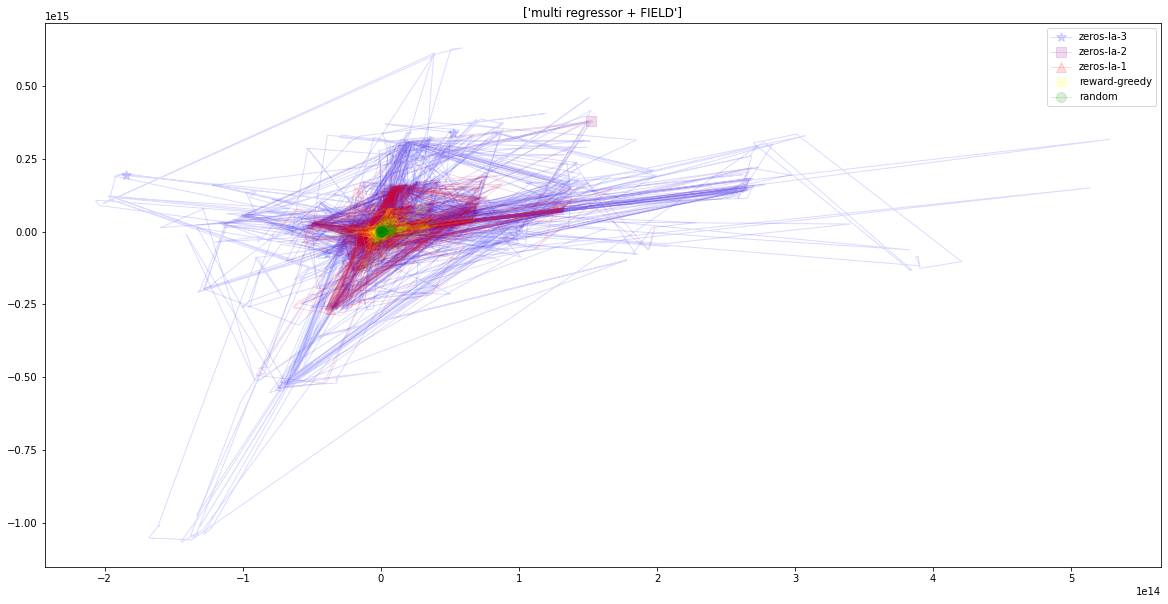

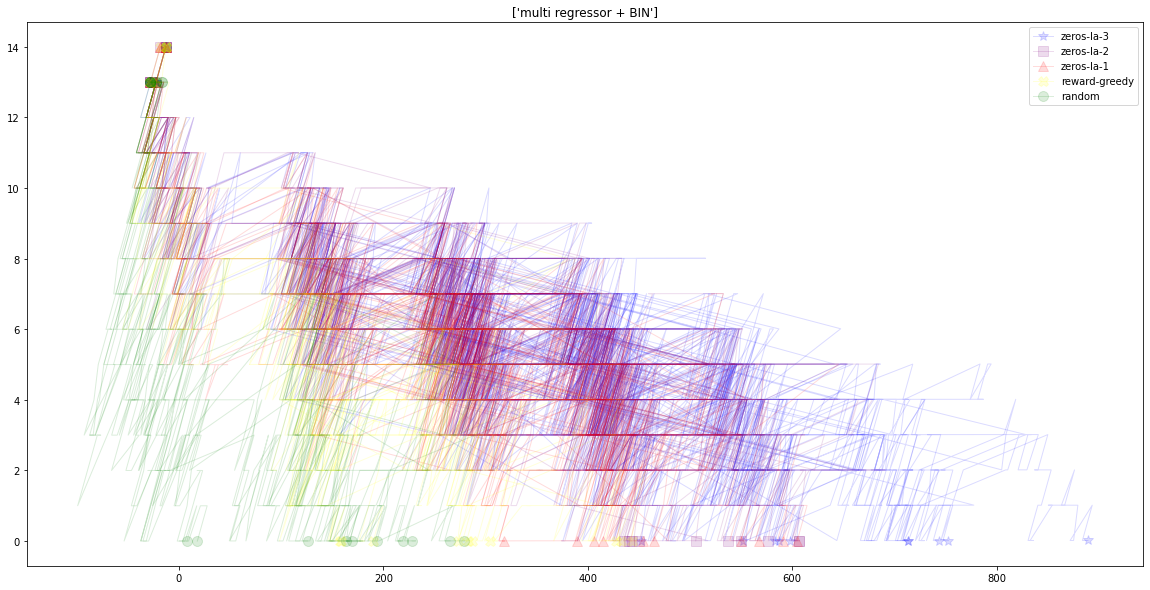

In [4]:
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor

# supervised: fit field or bins to step + zeros + 
for DATA_NAME, DATA in (("FIELD", FIELD_), ("BIN", BIN_)):
    xy = df[DATA].to_numpy()
    
    sgd = MultiOutputRegressor(SGDRegressor())
    sgd.fit(xy, df[["step", "zeros"]]) # "reward", "biggest", "sum"
    xy = sgd.predict(xy)
    
    plot_lines(xy, "multi regressor")

In [5]:
"""
Theoretical concepts: https://i-systems.github.io/teaching/ML/iNotes/15_Autoencoder.html
Instead of manually building the 2-part-encoder, we can just "chop off the head" of a neural network at any 
layer by setting the n_layers_ to a specific number, due to it not iterating over layers, but range(n_layers)

"""

LAB = ["step", "zeros", "sum", "biggest"] + FIELD_
# LAB = ["step", "zeros"] + BIN_

xy = df[LAB].to_numpy()

"""
Sadly this is REALLY slow for 4x4 data, so I tried using pytorch

print(len(DATA), len(xy))

NR_FEAT = len(df) - 2margins
mlp = MLPRegressor(hidden_layer_sizes=(NR_FEAT, 2, NR_FEAT), 
                   solver = 'adam', # sgd, adam, 
                   activation="identity",
                   learning_rate_init = 0.001, 
                   learning_rate = "adaptive")
# mlp.loss = "log_loss" # didn't really help the encoding too much

mlp.fit(xy, xy)
xy = df[LAB].to_numpy()
mlp.n_layers_ = mlp.hidden_layer_sizes.index(2)+2  # index of the 2-layer
pred = mlp.predict(xy)
print(pred.shape)

plot_lines(pred, DATA_NAME)
""";

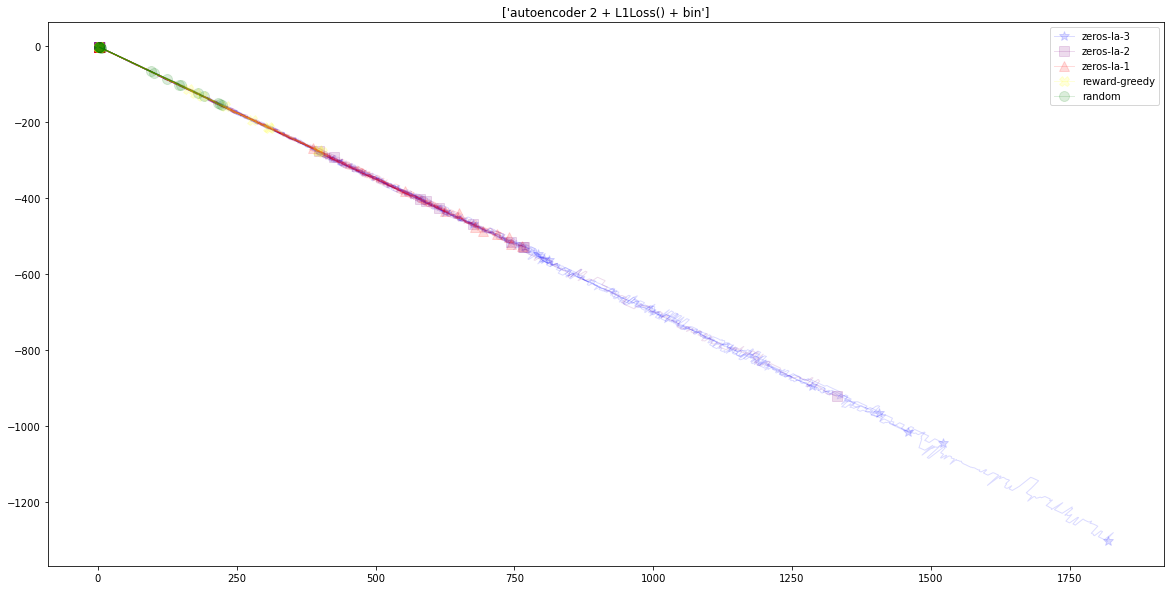

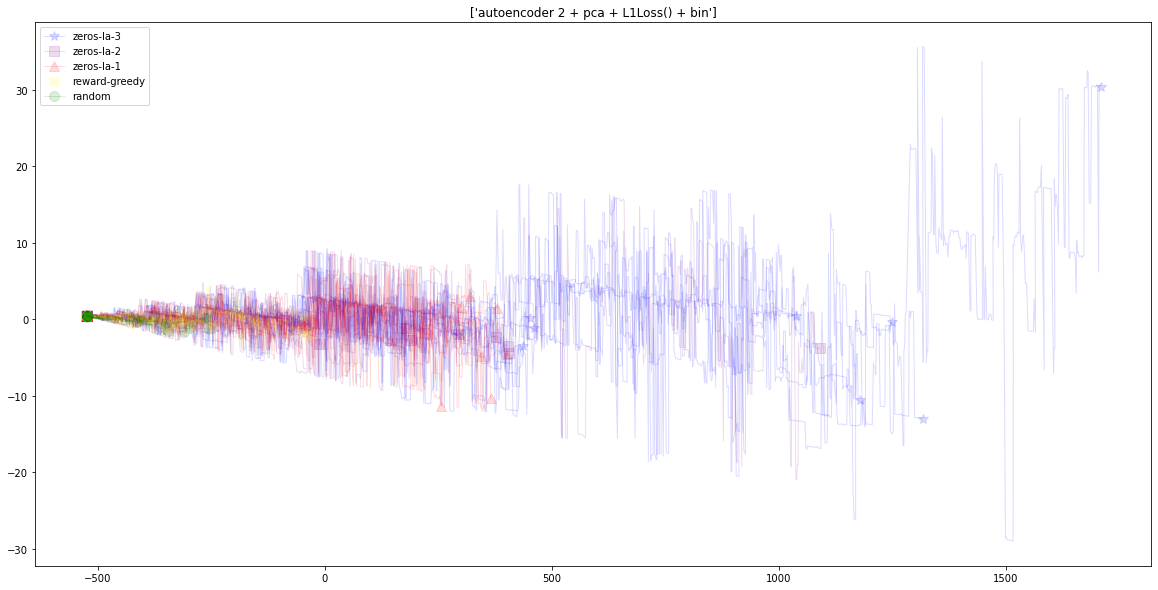

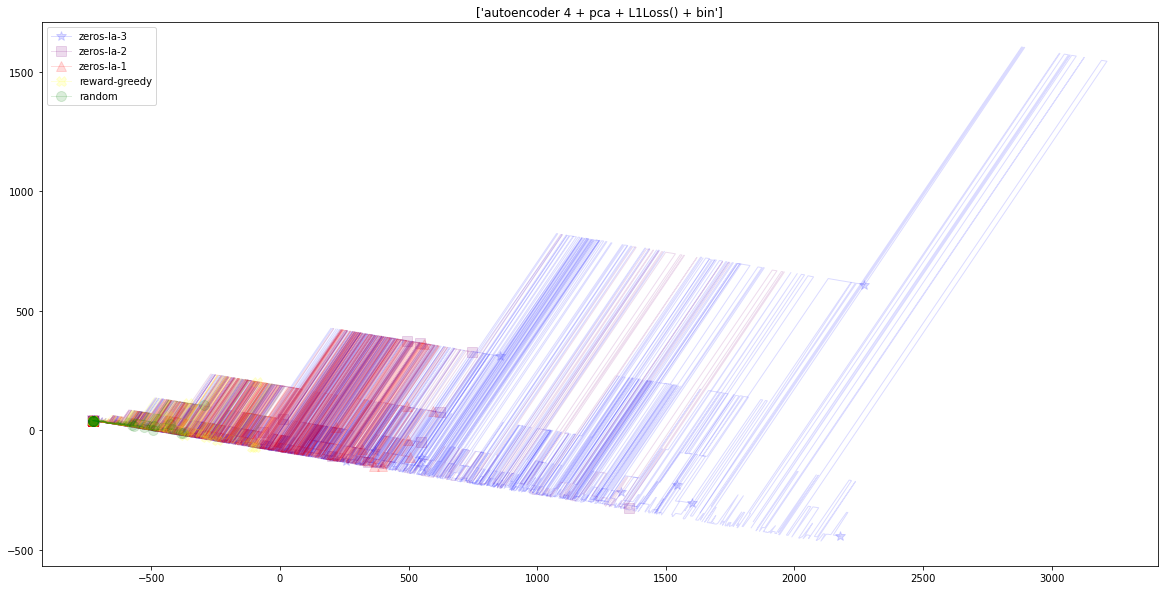

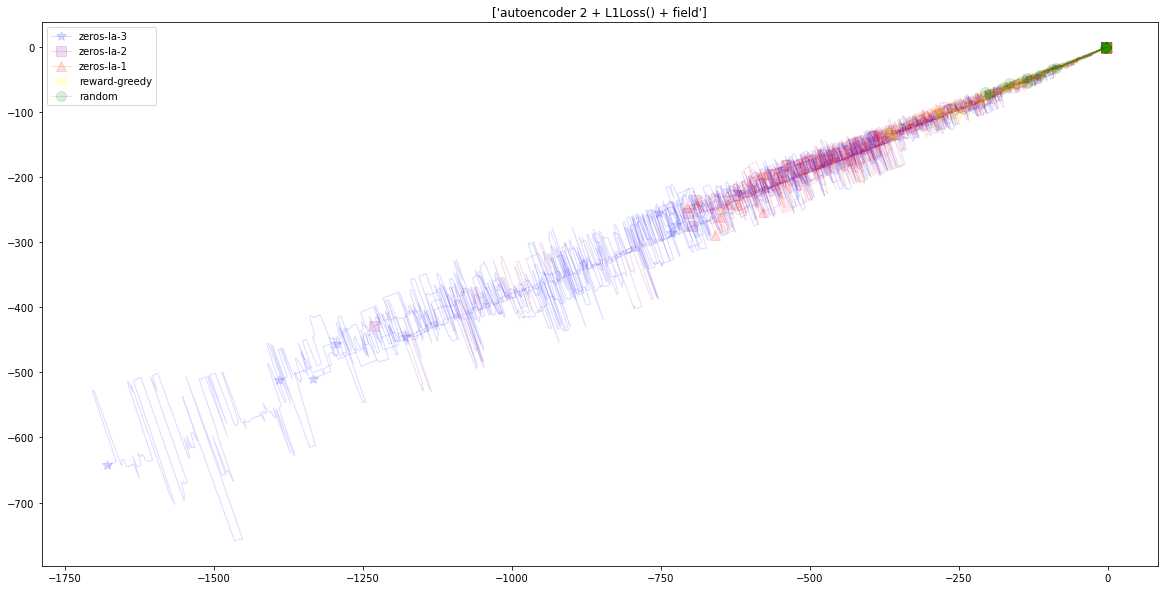

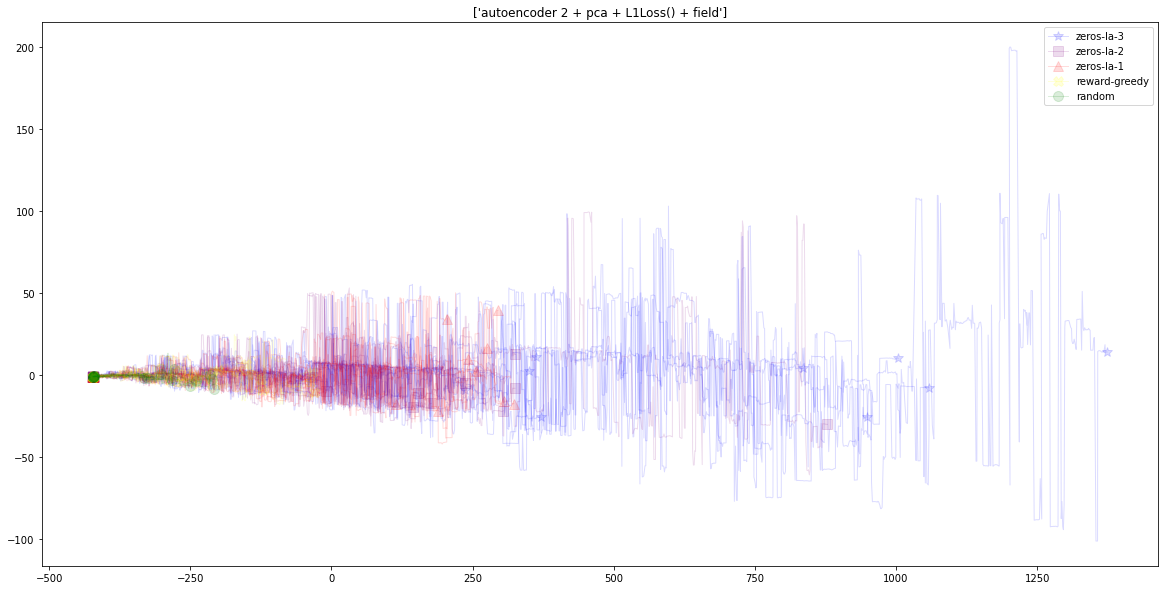

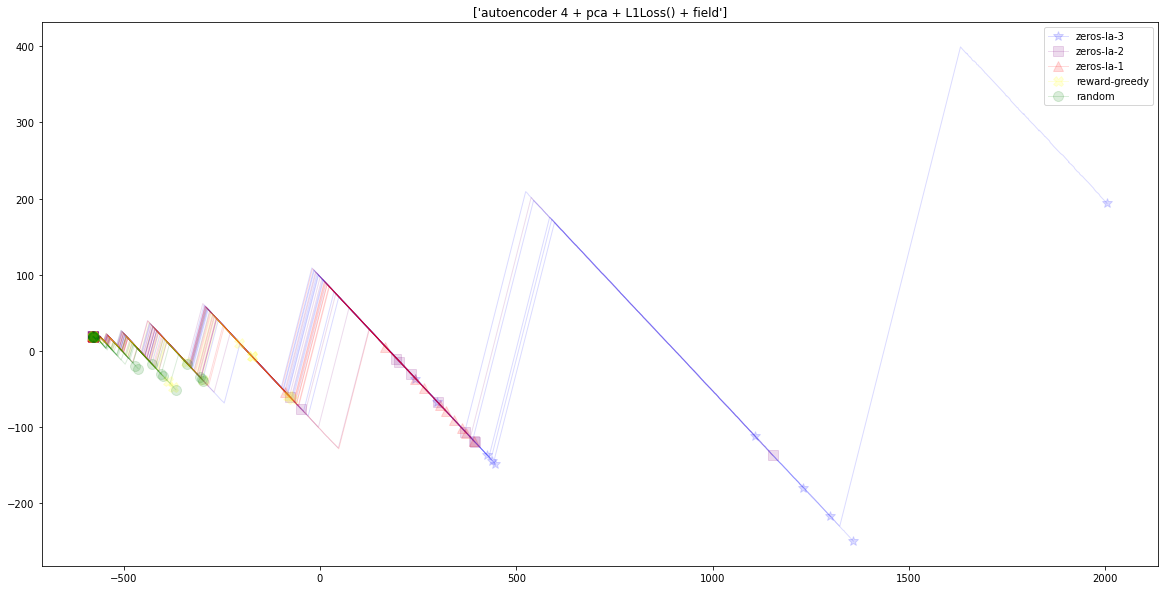

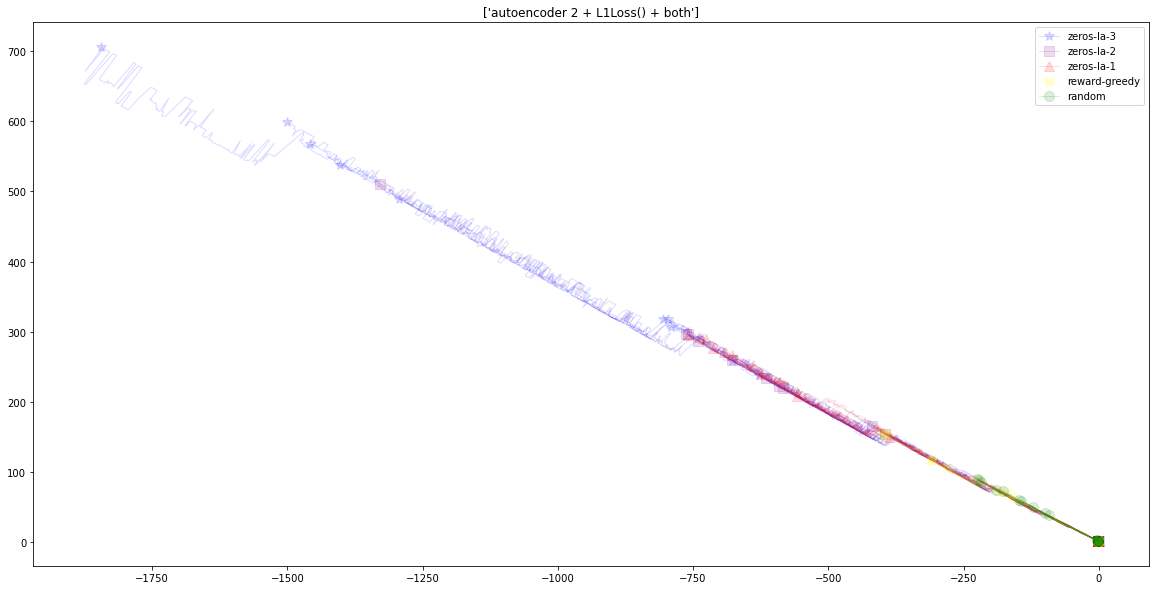

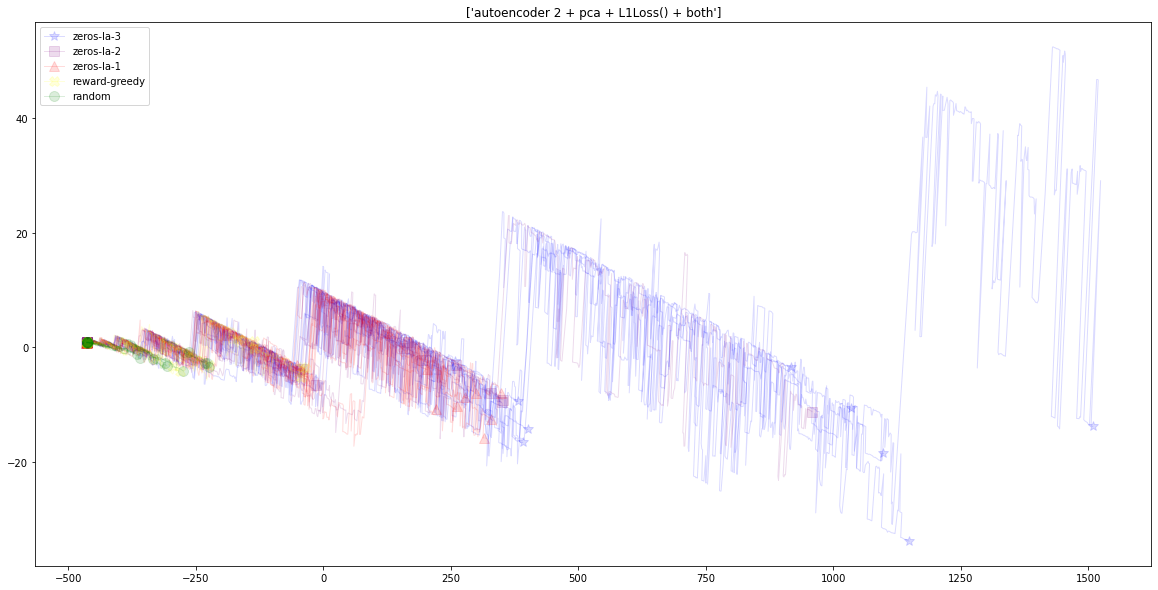

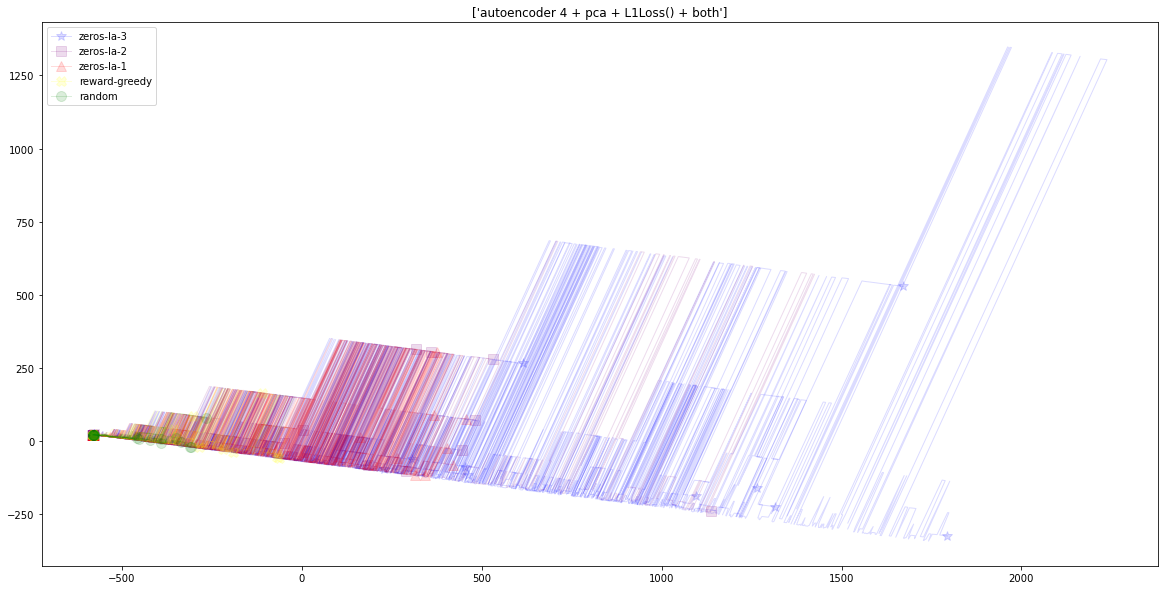

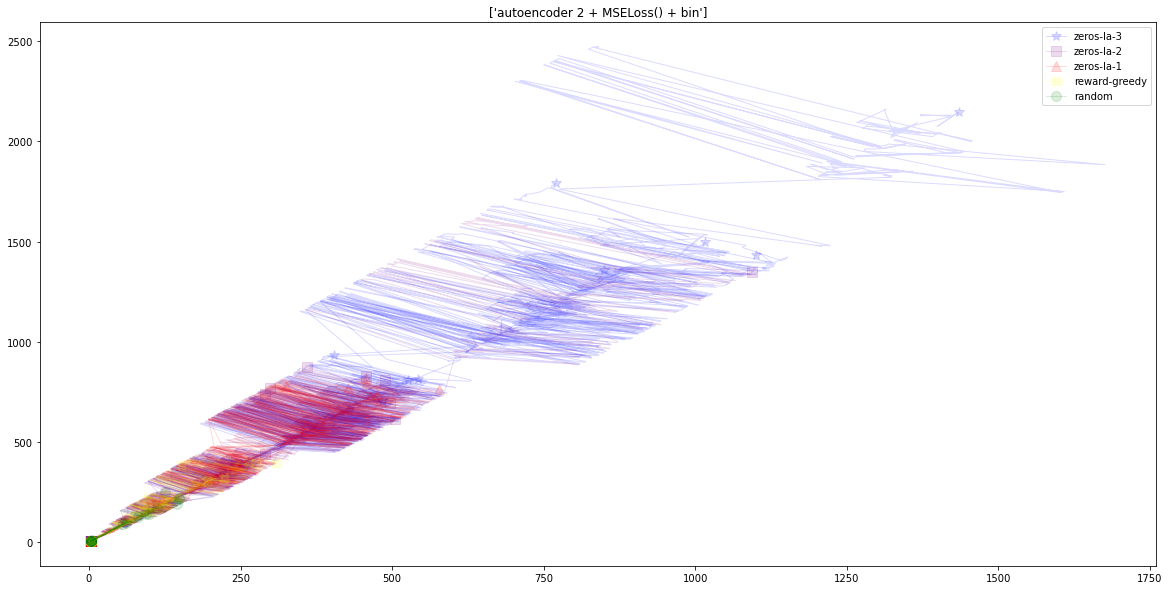

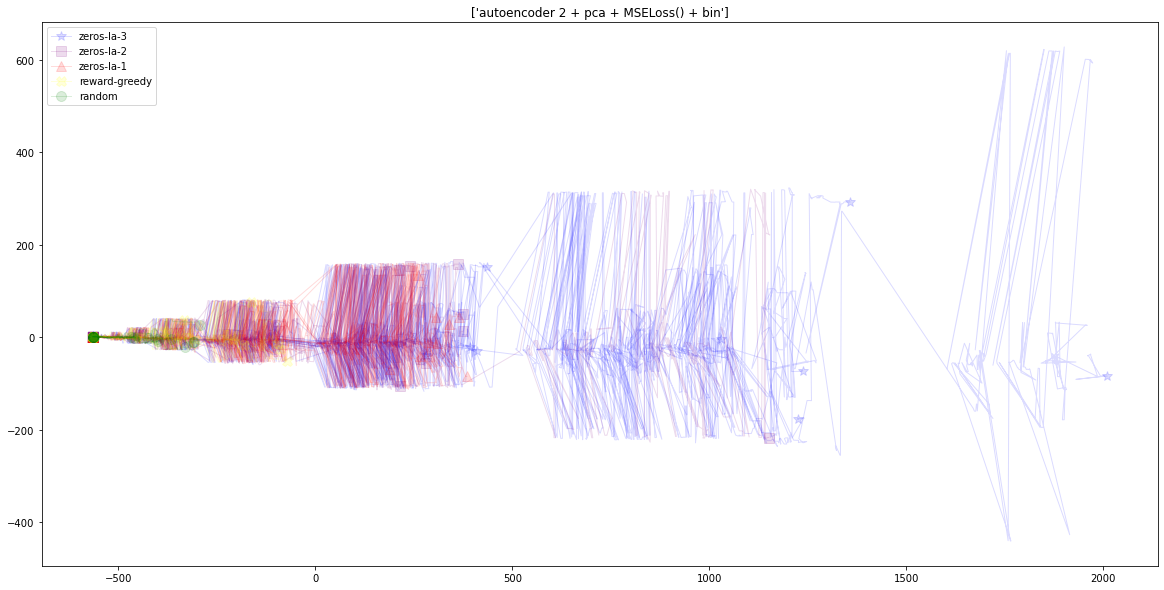

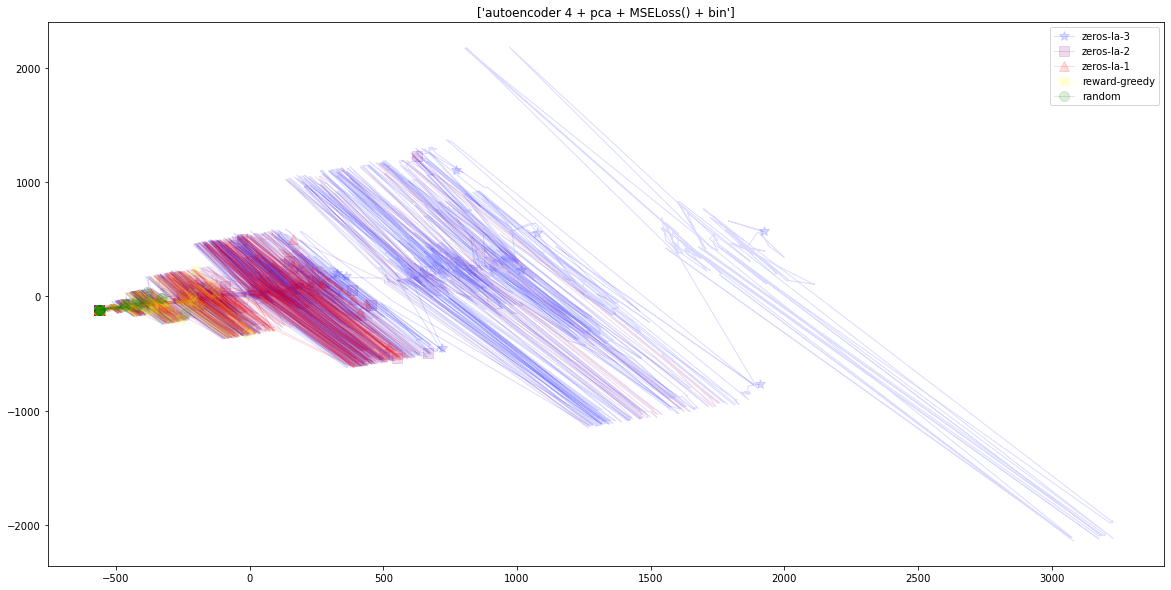

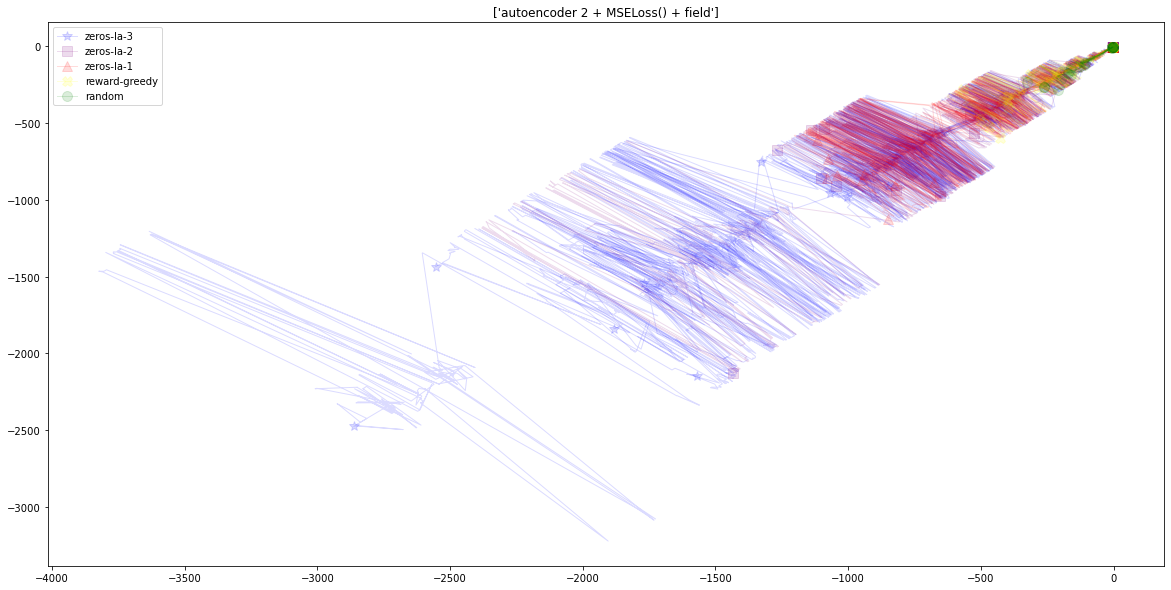

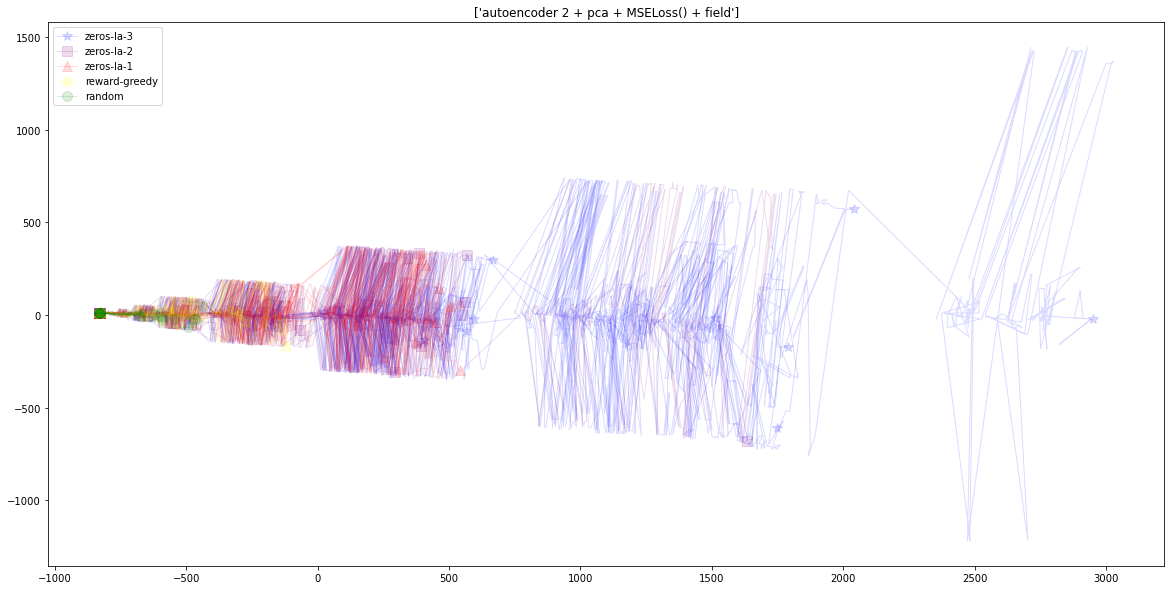

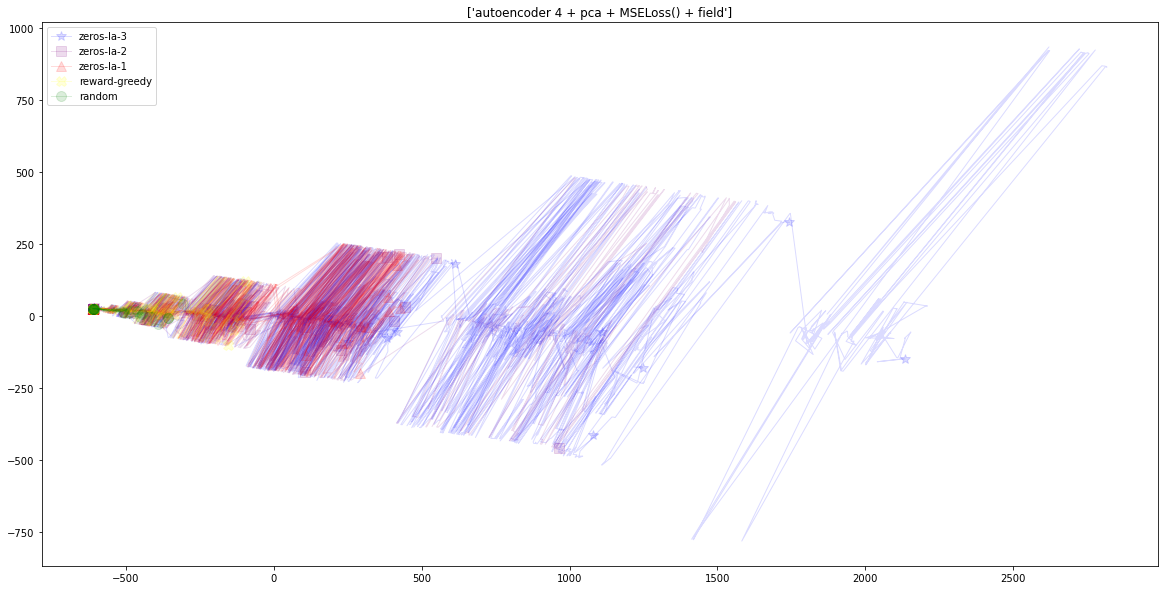

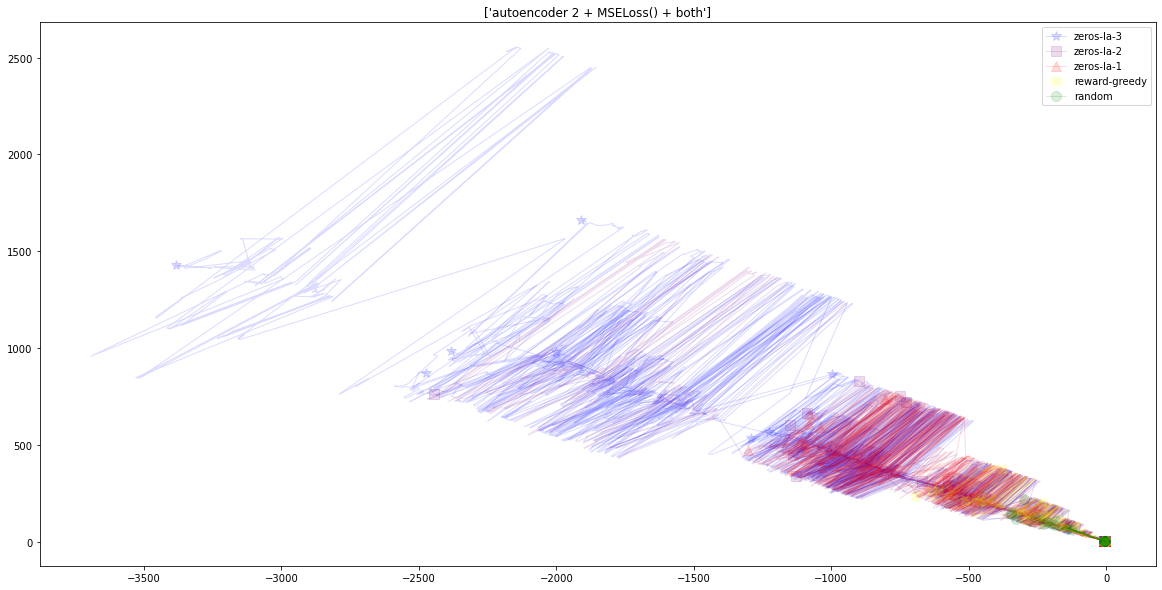

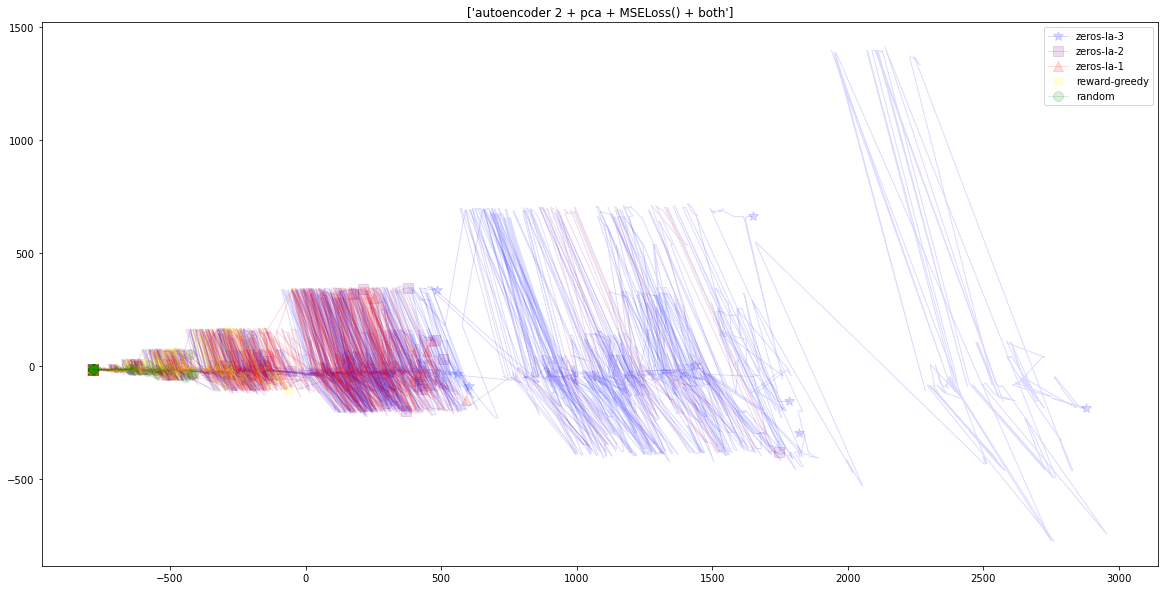

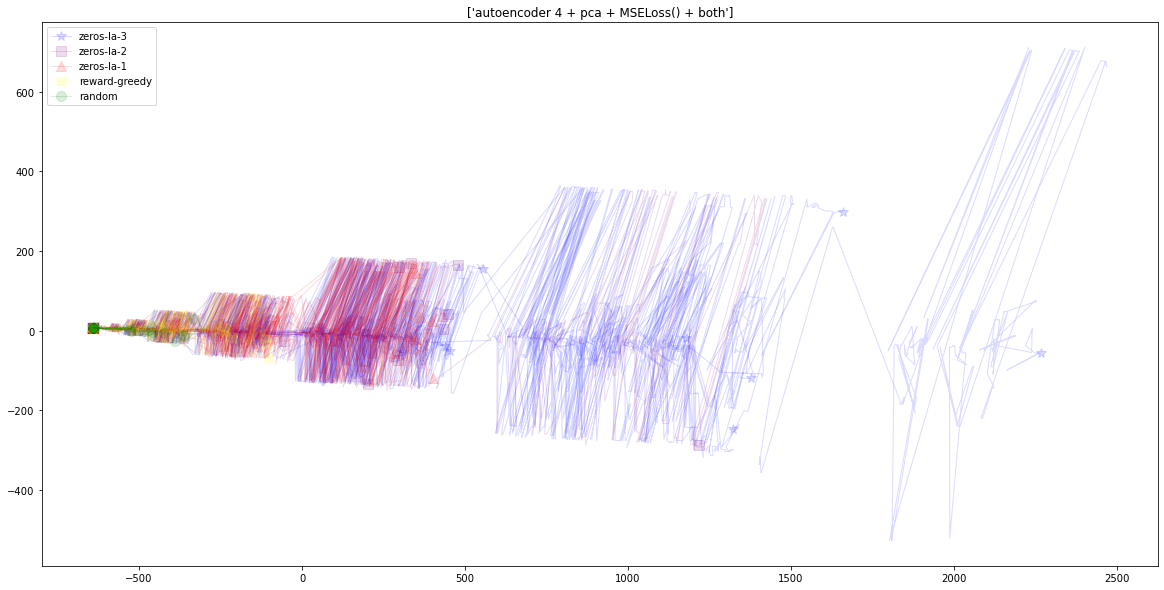

In [6]:
import torch.optim as optim
import torch.nn as nn
import torch
from sklearn.decomposition import PCA


def embed(xy, n_hidden = 20, n_hidden2 = 2, criterion = nn.L1Loss(), batch_size = 2**14, device="cuda", max_iter = 10000,
          lr=0.001, early_stop_tresh=1.001, verbose=True):
    """ Autoencoder with 2 layers """
    l0 = nn.Linear(len(xy[0]), n_hidden) # bias=False
    l1 = nn.Linear(n_hidden, n_hidden2) # bias=False
    l2 = nn.Linear(n_hidden2, n_hidden) # bias=False
    l3 = nn.Linear(n_hidden, len(xy[0])) # bias=False
    
    encoder = nn.Sequential(l0, l1)
    decoder = nn.Sequential(l2, l3)
    net = nn.Sequential(encoder, decoder)
    
    if verbose:
        print(l0, l1)

    # optimizer = optim.SGD(params=net.parameters(), lr=lr)
    optimizer = optim.Adam(params=net.parameters(), lr=lr)
    
    inputs = torch.Tensor(xy).to(device)
    net.to(device)

    running_losses = [1e10]
    for epoch in range(max_iter):  # loop over the dataset multiple times
        running_loss = 0.0
        for i in range(0, len(xy), batch_size):
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            inp = inputs[i:i+batch_size]
            outputs = net(inp)
            loss = criterion(outputs, inp)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        running_losses.append(running_loss)

        if not epoch % 100:
            if verbose:
                print(epoch, running_loss)
            best = net.state_dict()
            # early stopping: if the improvement is less than 0.1%
            if max(running_losses[-100:]) <= running_loss * early_stop_tresh:
                if verbose:
                    print("early stopping")
                break
    
    net.load_state_dict(best)
    return encoder(inputs).to("cpu").detach().numpy()

BASE = ["step", "zeros", "sum", "biggest"]
for loss in [nn.L1Loss() , nn.MSELoss()]:
    for DATA_NAME, lab in {"bin": BASE + BIN_, "field": BASE + BIN_, "both": BASE + BIN_ + FIELD_}.items():
        xy = xy = df[LAB].to_numpy()

        embedding_2 = embed(xy, n_hidden=2, verbose=False, criterion=loss)
        plot_lines(embedding_2, f"autoencoder 2 + {loss}")

        embedding_2_pca = PCA(n_components=2).fit_transform(embedding_2)
        plot_lines(embedding_2_pca, f"autoencoder 2 + pca + {loss}")

        embedding_4 = embed(xy, n_hidden=4, verbose=False, criterion=loss)
        embedding_4_pca = PCA(n_components=2).fit_transform(embedding_4)
        plot_lines(embedding_4_pca, f"autoencoder 4 + pca + {loss}")